# Simulation and visualization of spatial model

In this notebook the spatial model used for the analysis of the proliferation cell count data is simulated and visualized.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# exec(open('../settings.py').read(), globals())

In [2]:
model_parameters_uninjured = dict(
    SOX2_mean = 7.0,
    SOX2_sigma_intra = 0.5,
    SOX2_sigma_inter = 1,
    
    GF_left_mean = 0.5,
    GF_right_mean = 0.8,
    GF_sigma_inter = 0.04,
    
    mi_left_mean = 0.015,
    mi_right_mean = 0.1,
    mi_sigma_inter = 0.003,
    
    switchpoint_mean = 1e8, # far away
    switchpoint_sigma_inter = 0.1,
)

In [3]:
model_parameters_regenerating = model_parameters_uninjured.copy()
model_parameters_regenerating['switchpoint_mean'] = -0.3

In [4]:
def state(GF, mi):
    if sp.random.binomial(1, GF):
        if sp.random.binomial(1, mi):
            state = 'Cycling, mitotic'
        else:
            state = 'Cycling, non-mitotic'
    else:
        state = 'Quiescent'
        
    return state

In [5]:
def simulate_model(model_parameters, N, xmin, xmax, lcell):
    
    IDlist = []
    xlist = []
    ylist = []
    statelist = []
    for ID in sp.arange(N) + 1:
        
        SOX2_ID = sp.random.normal(model_parameters['SOX2_mean'], model_parameters['SOX2_sigma_inter'])
        GF_left_ID = sp.random.normal(model_parameters['GF_left_mean'], model_parameters['GF_sigma_inter'])
        GF_right_ID = sp.random.normal(model_parameters['GF_right_mean'], model_parameters['GF_sigma_inter'])
        mi_left_ID = sp.random.normal(model_parameters['mi_left_mean'], model_parameters['mi_sigma_inter'])
        mi_right_ID = sp.random.normal(model_parameters['mi_right_mean'], model_parameters['mi_sigma_inter'])
        switchpoint_ID = sp.random.normal(model_parameters['switchpoint_mean'], model_parameters['switchpoint_sigma_inter'])
        
        for x in sp.arange(xmin, xmax + lcell, lcell):
            
            SOX2_section = sp.around(sp.random.normal(SOX2_ID, model_parameters['SOX2_sigma_intra']))
            
            for y in sp.linspace(-0.5 * (SOX2_section - 1) * lcell, 0.5 * (SOX2_section - 1) * lcell, SOX2_section, endpoint=True):
                IDlist.append(ID)
                xlist.append(x)
                ylist.append(y)
                
                # choose state of cell
                
                if x < switchpoint_ID:
                    statelist.append(state(GF_left_ID, mi_left_ID))
                else:
                    statelist.append(state(GF_right_ID, mi_right_ID))
                
        
    cells = pd.DataFrame()
    cells['ID'] = IDlist
    cells['x'] = xlist
    cells['y'] = ylist
    cells['state'] = statelist
    return cells

In [6]:
def plot_model(fig, cells, s = 20, padx = 10, pady = 3, xlim = None, ylim = None):
    lcell = cells.at[0, 'y'] - cells.at[1, 'y'] # that's a bit dangourous. it assumes there are at least 2 cells along the y-axis
    colordict = {'Cycling, non-mitotic': (0, 158./255., 115./255.), 'Cycling, mitotic': (204./255., 121./255., 167./255.), 'Quiescent': (0, 0, 0)}
    xmin = cells['x'].min()
    xmax = cells['x'].max()
    ymin = cells['y'].min()
    ymax = cells['y'].max()
    ax = {}
    for i, (ID, ccells) in enumerate(cells.groupby('ID')):
        ax[i] = fig.add_subplot(len(cells.groupby('ID')), 1, i + 1)
        ax[i].set_xlim((xmin - padx, xmax + padx))
        ax[i].set_ylim((ymin - pady, ymax + pady))
        ax[i].spines['right'].set_color('none')
        ax[i].spines['left'].set_color('none')
        ax[i].spines['top'].set_color('none')
        ax[i].spines['bottom'].set_color('none')
        ax[i].tick_params(axis='x', colors='white')
        ax[i].set_yticks([])
        ax[i].set_ylabel("   Replicate {}".format(int(ID)), rotation = 'horizontal', labelpad = 0)
        ax[i].set_aspect('equal')

        ax[i].scatter(ccells['x'].values, ccells['y'].values, color = [colordict[state] for state in ccells['state'].values], s = s)
        ax[i].set_xlim(xlim)
        ax[i].set_ylim(ylim)

    ax[i].tick_params(axis='x', colors='black', labelsize = 8)
    ax[i].spines['bottom'].set_color('black')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].set_xlabel('AP position (mm)')

In [7]:
sp.random.seed(0)
lcell = 40/1000.
cells_uninjured = simulate_model(model_parameters_uninjured, 3, -1, 0, lcell)
cells_regenerating = simulate_model(model_parameters_regenerating, 3, -1, 0.5, lcell)

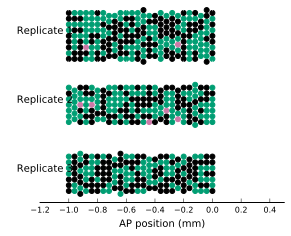

In [8]:
fig = plt.figure(figsize=(5, 3.5))
s = 25
xlim = (-1.2, 0.5)
ylim = (-0.2, 0.2)
plot_model(fig, cells_uninjured, s = s, xlim = xlim, ylim = ylim)
plt.savefig('../../figure_plots/supplement_Fig.2D_uninjured.svg')
plt.show()

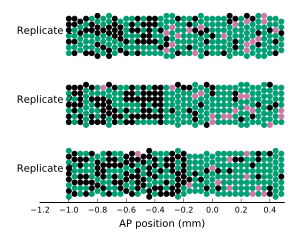

In [9]:
fig = plt.figure(figsize=(5, 3.5))
plot_model(fig, cells_regenerating, s = s, xlim = xlim, ylim = ylim)
plt.savefig('../../figure_plots/supplement_Fig.2D_regenerating.svg')
plt.show()